## Python notebook demonstrating IOOS QC Tests for Salinity Data

Created: 2024-09-29

Updated: 2024-09-29

This notebook walks you through a demonstration of the IOOS QC Spike Test. More information about IOOS QC can be found in the Github repository [here](https://github.com/ioos/ioos_qc)

The `ioos_qc` is collection of utilities, scripts and tests designed to assist in automated quality assurance and quality control for oceanographic datasets and observing systems. 

Let's take a look at how these tests work!!

First, we will set up the environment by importing the essential modules from the `ioos_qc` library.

In [1]:
from ioos_qc.qartod import aggregate
from ioos_qc.streams import XarrayStream
from ioos_qc.results import collect_results, CollectedResult
from ioos_qc.config import Config
from ioos_qc.utils import isfixedlength


Now, let's import various libraries necessary for handling netCDF files, arrays, plotting, and suppressing warnings.

In [2]:
from netCDF4 import Dataset
from cftime import num2pydate
from collections import namedtuple
import numpy.ma as ma
import numpy as np
import pandas as pd
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import warnings
# Suppress all warnings
warnings.filterwarnings('ignore')

The flags (`GOOD`, `UNKNOWN`, `SUSPECT`, `FAIL`, `MISSING`) are essential for interpreting the quality of oceanographic data after QC tests are applied. These flags indicate the reliability of the data.

The `QartodFlags` class represents the standard QARTOD (Quality Assurance of Real-Time Oceanographic Data) flagging system used for data quality assessment.

In [3]:
class QartodFlags(object):
    """Primary flags for QARTOD."""
    GOOD = 1
    UNKNOWN = 2
    SUSPECT = 3
    FAIL = 4
    MISSING = 9

FLAGS = QartodFlags  # Default name for all check modules
NOTEVAL_VALUE = QartodFlags.UNKNOWN

In [4]:
# define your variable here
name = 'salinity' #'temperature'

In [5]:
# path to nc file here
nc_path = 'jupyterbook/content/code_gallery/data/qartod.nc'

Read the NetCDF file specified in `nc_path` using the `netCDF4` library. The file is opened in read-only mode, and the `set_auto_maskandscale` parameter is set to False to prevent automatic masking and scaling of the data.

In [6]:
# read your file with netCDF4

with open(nc_path, 'r') as nc:
    nc  = Dataset(nc_path, 'r', set_auto_maskandscale=False)


In [7]:
# read file with xarray

nd = xr.open_dataset(
                nc_path,
                decode_cf=True,
                decode_coords=True,
                decode_times=True,
                mask_and_scale=True
            )

Define a variable configfile that is used to specify the path to a YAML configuration file. The file is read using the yaml library, and the contents are stored in the config variable.

In [8]:
# add a path to configuration file here
configfile = 'jupyterbook/content/code_gallery/data/qartodConfig.yml'

# read your file
with open(configfile, 'r') as nf:
    config = yaml.safe_load(nf.read())


In [9]:
# define specs for the spike test

# data read with xarray
xdata = nd[name].values
tdata = nd['time'].values.tolist()

# data read with netCDF4
# xdata = nc.variables[name][:]
# tdata = nc.variables['time'][:]


mask = np.zeros(xdata.shape[0], dtype=bool)

if hasattr(xdata, 'mask'):
        mask |= xdata.mask

vdata = ma.getdata(xdata[~mask])
std = np.nanstd(vdata)

# spike test specs
suspect_threshold = np.float64(1.0 * std)
fail_threshold = np.float64(2.0 * std)

# rate of change test
threshold = (3 * std) / np.median(np.diff(tdata))

In [10]:
# update configuration file
spec = config['contexts'][0]['streams'][name]['qartod']

spec['spike_test']['suspect_threshold'] = suspect_threshold
spec['spike_test']['fail_threshold'] = fail_threshold
spec['rate_of_change_test']['threshold'] = threshold
suspect_span = spec['gross_range_test']['suspect_span']
fail_span = spec['gross_range_test']['fail_span']

configset = {'contexts': [{'streams': {name: {'qartod': spec}}}]}
print(configset['contexts'][0]['streams'][name]['qartod']['spike_test']['suspect_threshold'])
print(configset['contexts'][0]['streams'][name]['qartod']['spike_test']['fail_threshold'])
print(configset['contexts'][0]['streams'][name]['qartod']['rate_of_change_test']['threshold'])
print(configset['contexts'][0]['streams'][name]['qartod']['gross_range_test']['suspect_span'])
print(configset['contexts'][0]['streams'][name]['qartod']['gross_range_test']['fail_span'])

0.42401437556171884
0.8480287511234377
4.211712597589028e-11
[10, 38]
[0, 42]


The below cell uses the `QARTOD` package to perform quality control on the data. The `Config` class is used to create a configuration object from the `configset` variable. The `XarrayStream` class is used to extract numpy arrays from the NetCDF file. The `run` method is used to perform the quality control tests, and the `results `are stored in the results variable.

In [11]:
# ##########                 # ##########
# ##########  QARTOD Package # ##########
# ##########                 # ##########

# GET the QC RESULTS
c_x = Config(configset)

# # Use XarrayStream to extract numpy arrays from
# # variables (stream_id) within the netCDF file.
qc_x = XarrayStream(nc_path)


# # Pass the run method and the config specs
# # Store as a list
runner = list(qc_x.run(c_x))

# # Create results
results = collect_results(runner, how='list')

# # Add the qc_rollup results
agg = CollectedResult(
                        stream_id=name,
                        package='qartod',
                        test='qc_rollup',
                        function=aggregate,
                        results=aggregate(results),
                        tinp=qc_x.time(),
                        data=qc_x.data(name)
                      )

results.append(agg)

Let's define a function `check_array` that checks if an array is constant or contains only NaN values. If the array is constant, the function returns a report indicating that the array is constant. If the array contains only NaN values, the function returns a report indicating that the array is NaN.

In [12]:
def check_array(obs):
    if len(np.unique(obs)) == 1:
        if np.ma.isMaskedArray(np.unique(obs)) | np.isnan(np.unique(obs)):
            report_1 = name + ' the array is nans ' + str(np.unique(obs))
            return report_1
        if np.unique(obs) == obs._FillValue:
            report_2 = name + ' the array is FillValues ' + str(np.unique(obs))
            return report_2

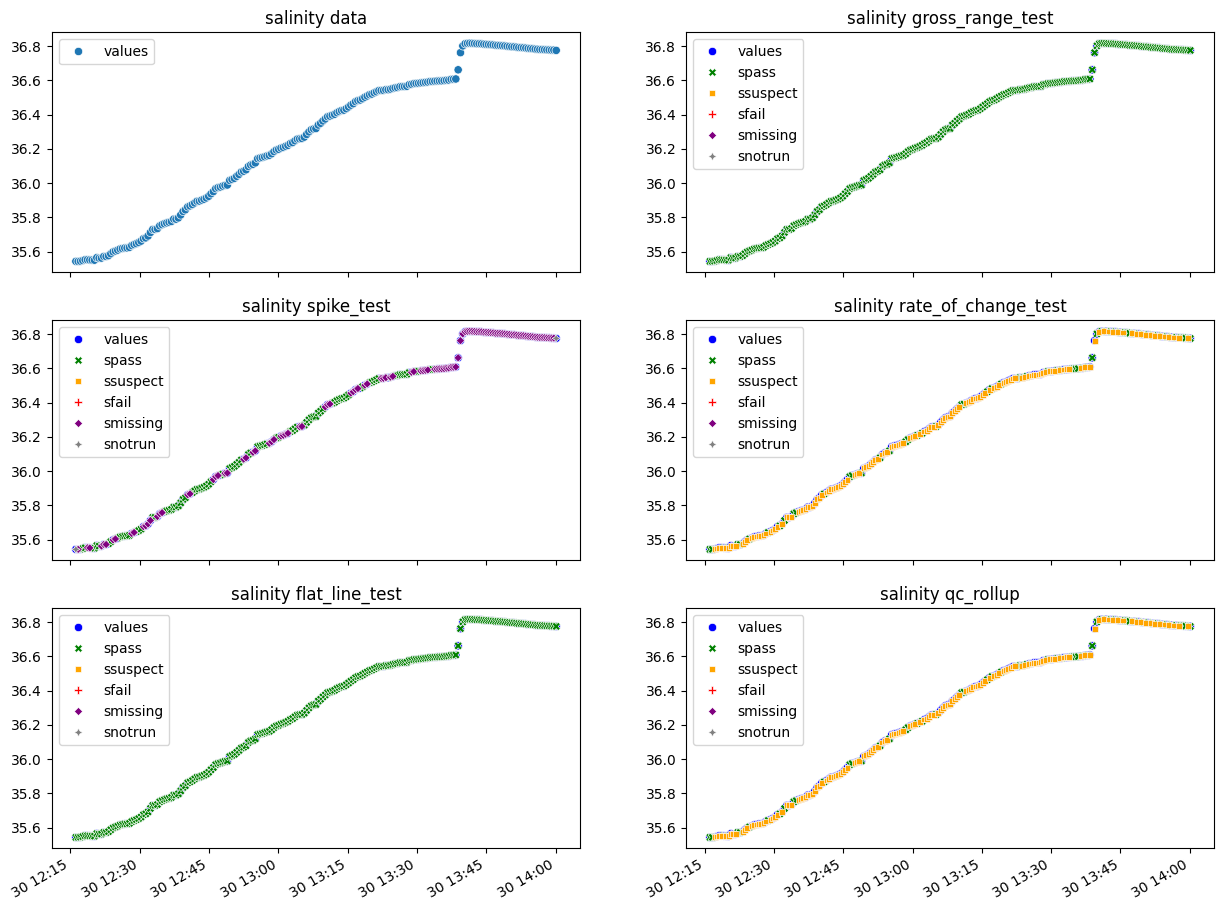

In [13]:
# plot the QARTOD flags of the test results

# data read with xarray
xdata = nd[name].values
tdata = nd['time'].values
df = pd.DataFrame(xdata, tdata, ["values"])

# print(tdata)


fig, axes = plt.subplots(3,2, sharex=True)

if check_array(xdata):
    sns.scatterplot(data=df, ax=axes.flatten()[0]).set(title= check_array(nc.variables[name][:]))
else:
    sns.scatterplot(data=df, ax=axes.flatten()[0]).set(title= name + ' data')

for r, ax in zip(results, axes.flatten()[1:6]):

    tf = r.results

    sdf = pd.DataFrame(xdata, tdata, ["values"])
    tf_suspect = np.ma.masked_where(tf != 3, xdata)
    tf_pass = np.ma.masked_where(tf != 1, xdata)
    tf_fail = np.ma.masked_where(tf != 4, xdata)
    tf_notrun = np.ma.masked_where(tf != 2, xdata)
    tf_missing = np.ma.masked_where(tf != 9, xdata)

    sdf['spass'] = tf_pass
    sdf['ssuspect'] = tf_suspect
    sdf['sfail'] = tf_fail
    sdf['smissing'] = tf_missing
    sdf['snotrun'] = tf_notrun

    sns.scatterplot(data=sdf,
                    palette=dict(values="blue", spass="green", ssuspect="orange",
                                 sfail="red",smissing="purple", snotrun="grey"),
                                 ax=ax).set(title= name + ' ' + r.test)

fig.autofmt_xdate()
plt.gcf().set_size_inches(15,12)
plt.show()

### Quality tests using spike test.

Implementing the logic to apply the spike test using the "average" method. This method calculates the difference between a point in the dataset and the average of its neighboring points. If the difference exceeds defined thresholds, the data point is flagged as `SUSPECT` or `FAIL`. The test also accounts for missing or undefined values.


After applying the spike test, the flag array is generated based on the thresholds. The array contains flags for each data point, indicating whether it is good, suspect, fail, or missing. This data is then reshaped to its original form for easy examination.


In [15]:
# ########## Qartod function: # ########## 
# ##########    spike_test    # ########## 
# ##########    manual run    # ##########

# define spike test input here
method = 'average' #used with the spike_test

# data read with xarray
x = nd[name].values

#########################
### start of the test ###

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    x = np.ma.masked_invalid(np.array(x).astype(np.float64))

# Save original shape
original_shape = x.shape
x = x.flatten()

# Apply different method
if method == 'average':
    # Calculate the average of n-2 and n
    ref = np.ma.zeros(x.size, dtype=np.float64)
    ref[1:-1] = (x[0:-2] + x[2:]) / 2

    ref = np.ma.masked_invalid(ref)

    # Calculate the (n-1 - ref) difference
    diff = np.abs(x - ref)

elif method == 'differential':
    ref = np.ma.diff(x)

    # Find the minimum variation prior and after the n value
    diff = np.ma.zeros(x.size, dtype=np.float64)
    diff[1:-1] = np.minimum(np.abs(ref[:-1]), np.abs(ref[1:]))

    # Make sure that only the record (n) where the difference
    # prior and after are opposite are considered
    with np.errstate(invalid='ignore'):
        diff[1:-1][ref[:-1]*ref[1:] >= 0] = 0
else:
    raise ValueError('Unknown method: "{0}", only "average" and \
                     "differential" methods are available'
                     .format(method))

# Start with everything as passing (1)
flag_arr = np.ma.ones(x.size, dtype='uint8')


# If n-1 - ref is greater than the low threshold, SUSPECT test
if suspect_threshold:
    with np.errstate(invalid='ignore'):
        flag_arr[diff > suspect_threshold] = QartodFlags.SUSPECT


# If n-1 - ref is greater than the high threshold, FAIL test
if fail_threshold:
    with np.errstate(invalid='ignore'):
        flag_arr[diff > fail_threshold] = QartodFlags.FAIL

# Test is undefined for first and last values
flag_arr[0]= QartodFlags.UNKNOWN
flag_arr[-1]= QartodFlags.UNKNOWN

# Check if the original data was masked
for i in range(x.size):
    # Check if both arr and diff are masked
    if x.mask[i]:
        flag_arr[i] = QartodFlags.MISSING

    # Check if diff is masked but not in arr (this indicates that original data is not missing, 
    # but the data point got masked in diff)
    elif (diff.mask[i] and not x.mask[i]):
        flag_arr[i] = QartodFlags.UNKNOWN

flag_arr = flag_arr.reshape(original_shape)


### end of the test ###
#######################

Examining the flagged data. The result is displayed in a pandas DataFrame, where each data point is associated with its respective flag. This allows for easy inspection of which points were flagged as missing, unknown, suspect, or failed.


In [16]:
# examining the spike test flag arrays
wf = pd.DataFrame(x, flag_arr, ['salinity'])
print('right column KEYS: ', 'Missing', QartodFlags.MISSING, 'UNKNOWN', QartodFlags.UNKNOWN, '\n')
print(wf)

right column KEYS:  Missing 9 UNKNOWN 2 

     salinity
2   35.542516
9         NaN
2   35.542454
1   35.544000
1   35.547508
..        ...
9         NaN
2   36.777225
2   36.777070
9         NaN
2   36.775241

[277 rows x 1 columns]



Plot the QC flags of the spike test results using the `seaborn` library. The plot shows the data values and the corresponding QC flags.

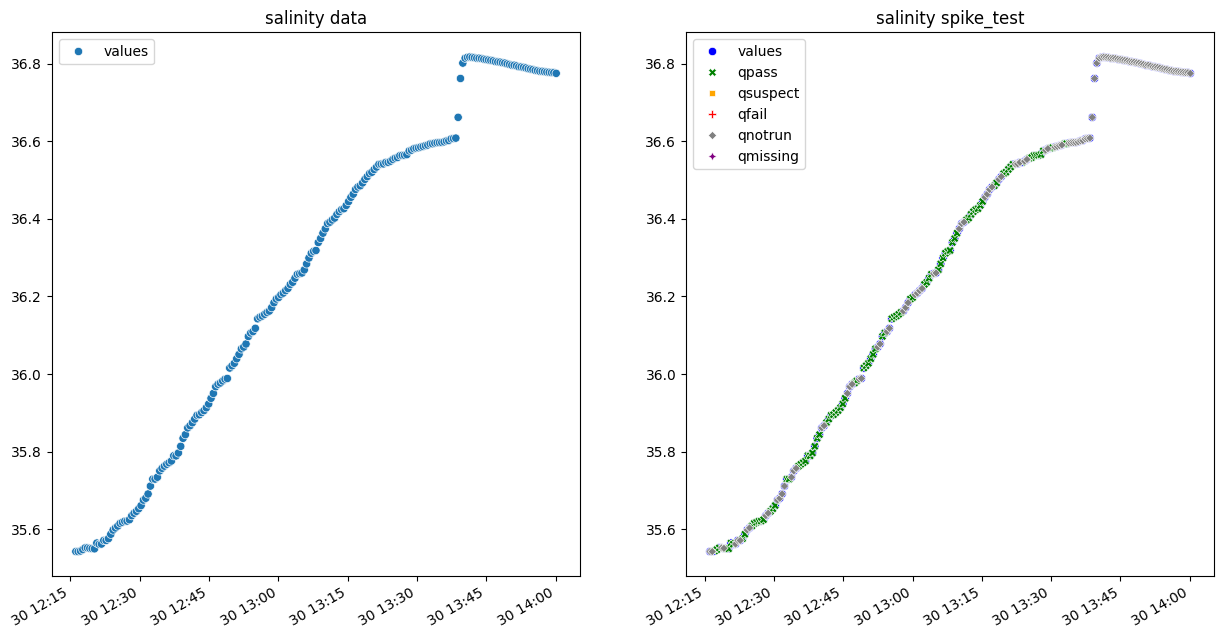

In [17]:
# ##########  plot qc flags    # ##########
# ##########  manual run       # ##########
# ##########  spike test       # ##########

# data read with xarray
xdata = nd[name].values
tdata = nd['time'].values
df = pd.DataFrame(xdata, tdata, ["values"])


fig, (ax1, ax2) = plt.subplots(1,2, sharex=True) #, sharex=True
sns.scatterplot(data=df, ax=ax1).set(title= name + ' data')

sdf = pd.DataFrame(x, tdata, ["values"]) # x is from the spike_test
qc_suspect = np.ma.masked_where(flag_arr != 3, xdata)
qc_pass = np.ma.masked_where(flag_arr != 1, xdata)
qc_fail = np.ma.masked_where(flag_arr != 4, xdata)
qc_notrun = np.ma.masked_where(flag_arr != 2, xdata)
qc_missing = np.ma.masked_where(flag_arr != 9, xdata)

sdf['qpass'] = qc_pass
sdf['qsuspect'] = qc_suspect
sdf['qfail'] = qc_fail
sdf['qnotrun'] = qc_notrun
sdf['qmissing'] = qc_missing

sns.scatterplot(data=sdf[sdf['values'] > 0],
                palette=dict(values="blue", qpass="green",
                             qsuspect="orange", qfail="red",
                             qnotrun="grey", qmissing="purple"),
                             ax=ax2).set(title= name + ' spike_test')

fig.autofmt_xdate()
plt.gcf().set_size_inches(15,8)
plt.show()

In [18]:
# ########## Qartod function:       # ########## 
# ########## rate_of_change_test    # ########## 
# ##########    manual run          # ##########

In [19]:
def mapdates(dates):
    if hasattr(dates, 'dtype') and hasattr(dates.dtype, 'tz'):
        # pandas time objects with a datetime component, remove the timezone
        return dates.dt.tz_localize(None).astype('datetime64[ns]').to_numpy()
    elif hasattr(dates, 'dtype') and hasattr(dates, 'to_numpy'):
        # pandas time objects without a datetime component
        return dates.to_numpy().astype('datetime64[ns]')
    elif hasattr(dates, 'dtype') and np.issubdtype(dates.dtype, np.datetime64):
        # numpy datetime objects
        return dates.astype('datetime64[ns]')
    else:
        try:
            # Finally try unix epoch seconds
            return pd.to_datetime(dates, unit='s').values.astype('datetime64[ns]')
        except Exception:
            # strings work here but we don't advertise that
            return np.array(dates, dtype='datetime64[ns]')

### Quality tests using Rate of change test.

Performing the rate of change test on the data using the `QARTOD` package. The test is performed by calculating the rate of change in units/second and comparing it to a threshold value.

In [20]:
# define rate_of_change_test input here

# data read with xarray
inp = nd[name].values
tinp = nd['time'].values

#########################
### start of the test ###

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    inp = np.ma.masked_invalid(np.array(inp).astype(np.float64))

# Save original shape
original_shape = inp.shape
inp = inp.flatten()

# Start with everything as passing (1)
flag_arr = np.ma.ones(inp.size, dtype='uint8')

# calculate rate of change in units/second
roc = np.ma.zeros(inp.size, dtype='float')

tinp = mapdates(tinp).flatten()

roc[1:] = np.abs(np.diff(inp) / np.diff(tinp).astype('timedelta64[s]').astype(float))

with np.errstate(invalid='ignore'):
    flag_arr[roc > threshold] = QartodFlags.SUSPECT


# If the value is masked set the flag to MISSING
flag_arr[inp.mask] = QartodFlags.MISSING

flag_arr = flag_arr.reshape(original_shape)

In [21]:
wf = pd.DataFrame(inp, flag_arr, ['salinity'])
print('right column KEYS: ', 'Missing', QartodFlags.MISSING, 'UNKNOWN', \
      QartodFlags.UNKNOWN, 'SUSPECT', QartodFlags.SUSPECT, '\n')
print(wf)

right column KEYS:  Missing 9 UNKNOWN 2 SUSPECT 3 

     salinity
1   35.542516
9         NaN
1   35.542454
3   35.544000
3   35.547508
..        ...
9         NaN
1   36.777225
3   36.777070
9         NaN
1   36.775241

[277 rows x 1 columns]


Ploting the QC flags of the rate of change test results using the `seaborn` library. The plot shows the data values and the corresponding QC flags.

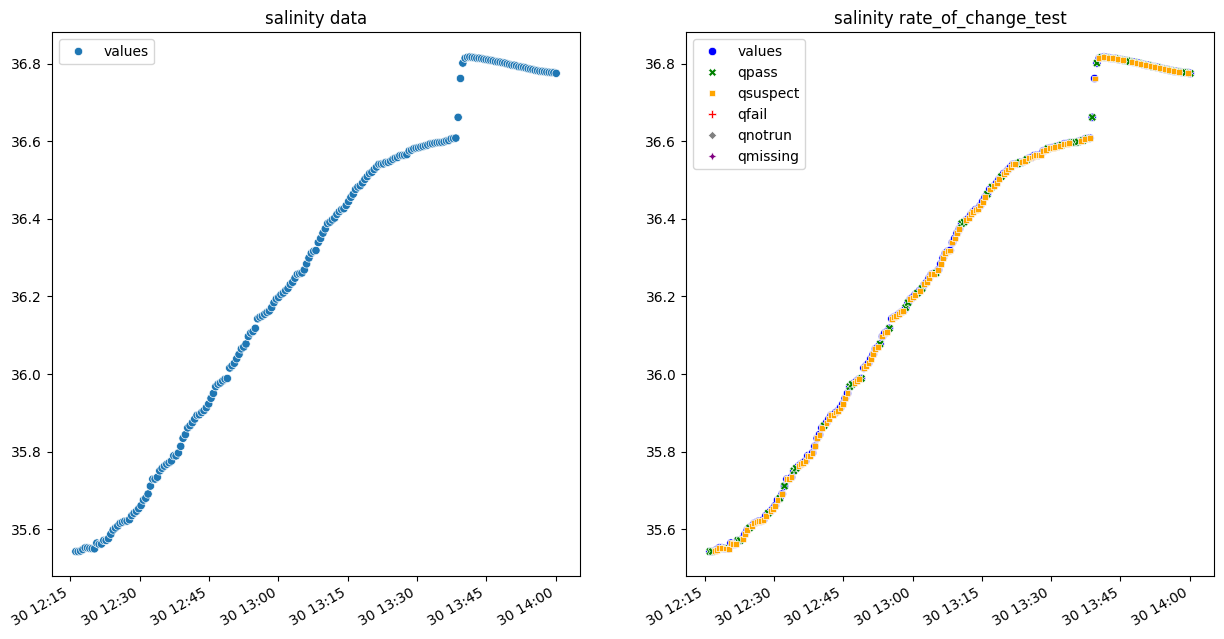

In [22]:
# ##########  plot qc flags         # ##########
# ##########  manual run            # ##########
# ##########  rate of change test   # ##########

# data read with xarray
xdata = nd[name].values
tdata = nd['time'].values
df = pd.DataFrame(xdata, tdata, ["values"])


fig, (ax1, ax2) = plt.subplots(1,2, sharex=True) #, sharex=True
sns.scatterplot(data=df, ax=ax1).set(title= name + ' data')

sdf = pd.DataFrame(x, tdata, ["values"]) # x is from the spike_test
qc_suspect = np.ma.masked_where(flag_arr != 3, xdata)
qc_pass = np.ma.masked_where(flag_arr != 1, xdata)
qc_fail = np.ma.masked_where(flag_arr != 4, xdata)
qc_notrun = np.ma.masked_where(flag_arr != 2, xdata)
qc_missing = np.ma.masked_where(flag_arr != 9, xdata)

sdf['qpass'] = qc_pass
sdf['qsuspect'] = qc_suspect
sdf['qfail'] = qc_fail
sdf['qnotrun'] = qc_notrun
sdf['qmissing'] = qc_missing

sns.scatterplot(data=sdf[sdf['values'] > 0],
                palette=dict(values="blue", qpass="green",
                             qsuspect="orange", qfail="red",
                             qnotrun="grey", qmissing="purple"),
                             ax=ax2).set(title= name + ' rate_of_change_test')

fig.autofmt_xdate()
plt.gcf().set_size_inches(15,8)
plt.show()